## Make Deep Learned Kernel with multioutput
-Could be useful: https://github.com/vlad17/runlmc

Links:
- https://github.com/GPflow/GPflow/pull/138 - coregion kernel
- https://github.com/GPflow/GPflow/pull/139 - coregion kernel
- https://en.wikipedia.org/wiki/Kernel_methods_for_vector_output#Linear_model_of_coregionalization_.28LMC.29  
- http://gpflow.readthedocs.io/en/latest/notebooks/coreg_demo.html?highlight=coregion  
- https://bigaidream.gitbooks.io/subsets_ml_cookbook/content/bayes/gp/coregionalized_regression_gpy.html - Gpy might be useful

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
%matplotlib inline

from modeling import Model

Using TensorFlow backend.


### Generate some data

In [2]:
#Code from https://github.com/dfm/gprv/blob/master/demo.ipynb
#which in turn was inspired from Rajpaul et al. (2015)
class SimpleKernel(Model):
    parameter_names = ("log_b", )
    
    def get_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return a * np.exp(-b * tau**2)
    
    def get_grad_1_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * tau * np.exp(-b * tau**2)
    
    def get_grad_2_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * np.exp(-b * tau**2) * (1.0 - 2 * b * tau**2)

class RVKernel(Model):
    parameter_names = ("vc", "vr", "lc", "bc", "br")
    
    def __init__(self, G, *args, **kwargs):
        self.G = G
        super(RVKernel, self).__init__(*args, **kwargs)
    
    def get_value(self, tau, l1, l2):
#         vc = np.exp(self.log_vc)
#         vr = np.exp(self.log_vr)
#         lc = np.exp(self.log_lc)
#         bc = np.exp(self.log_bc)
#         br = np.exp(self.log_br)
        vc = self.vc
        vr = self.vr
        lc = self.lc
        bc = self.bc
        br = self.br
        
        # Compute the value of gamma and its derivatives
        g = self.G.get_value(tau)
        gp1 = self.G.get_grad_1_value(tau)
        gp2 = self.G.get_grad_1_value(-tau)
        gpp = self.G.get_grad_2_value(tau)
        
        # We'll use these masks to build the blocked kernel matrix
        m11 = l1 == 1
        m12 = l1 == 2
        m13 = l1 == 3
        m21 = l2 == 1
        m22 = l2 == 2
        m23 = l2 == 3
        
        # Allocate the matrix and loop over blocks
        K = np.zeros_like(tau)
        zero_tau = np.isclose(tau, 0.0)
        
        # k11
        m = m11 * m21
        K[m] = vc**2*g[m] + vr**2*gpp[m] + vr*vc*(gp1 + gp2)[m]
        m &= zero_tau

        # k22
        m = m12 * m22
        K[m] = lc**2*g[m]
        m &= zero_tau

        # k33
        m = m13 * m23
        K[m] = bc**2*g[m] + br**2*gpp[m] + bc*br*(gp1 + gp2)[m]
        m &= zero_tau

        # k12
        m = m11 * m22
        K[m] = vc*lc*g[m] + vr*lc*gp2[m]
        m = m12 * m21
        K[m] = vc*lc*g[m] + vr*lc*gp1[m]

        # k13
        m = m11 * m23
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp1[m] + vr*bc*gp2[m]
        m = m13 * m21
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp2[m] + vr*bc*gp1[m]

        # k23
        m = m12 * m23
        K[m] = lc*bc*g[m] + lc*br*gp1[m]
        m = m13 * m22
        K[m] = lc*bc*g[m] + lc*br*gp2[m]

        return K

In [3]:
func = SimpleKernel(0.1)
kernel = RVKernel(func, 1.0, 1.0, 0.6, 0.3, 0.5)

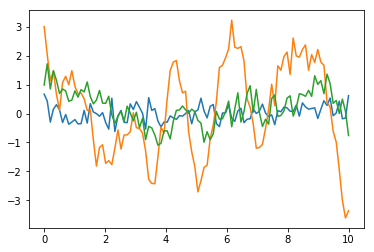

In [4]:
#generate some correlated time series according to a kernel K
npts = 100
output_dim = 3

time = np.linspace(0, 10, npts)
index = np.zeros(len(time))
t, l = np.zeros(0), np.zeros(0)
for i in range(output_dim):
    t = np.concatenate((t,time))
    l = np.concatenate((l,index + i))

Kern = kernel.get_value(t[:, None] - t[None, :], l[:, None], l[None, :])
Kern[np.diag_indices(len(t))] += 0.1
y = np.random.multivariate_normal(np.zeros_like(t), Kern)

for i in range(output_dim):
    line, = plt.plot(t[l==i], y[l==i])

### Deep Learned Kernel, alternate

In [19]:
from gpflow.params import Parameterized
from gpflow import Param
from gpflow.kernels import RBF

#Xavier random initialization of NN weights
def xavier(dim_in, dim_out):
    return np.random.randn(dim_in, dim_out)*(2./(dim_in+dim_out))**0.5

class NN(Parameterized):
    def __init__(self, dims):
        Parameterized.__init__(self)
        self.dims = dims
        for i, (dim_in, dim_out) in enumerate(zip(dims[:-1], dims[1:])):
            setattr(self, 'W_{}'.format(i), Param(xavier(dim_in, dim_out)))
            setattr(self, 'b_{}'.format(i), Param(np.zeros(dim_out)))

    def forward(self, X):
        if X is not None:
            for i in range(len(self.dims) - 1):
                W = getattr(self, 'W_{}'.format(i))
                b = getattr(self, 'b_{}'.format(i))
                X = tf.nn.tanh(tf.matmul(X, W) + b)
            return X

class NN_RBF(RBF):
    def __init__(self, nn, *args, **kw):
        RBF.__init__(self, *args, **kw)
        self.nn = nn
    
    def square_dist(self, X, X2):
        return RBF.square_dist(self, self.nn.forward(X), self.nn.forward(X2))

## Pristine Version ##
# def xavier(dim_in, dim_out):
#     return np.random.randn(dim_in, dim_out)*(2./(dim_in+dim_out))**0.5

# class NN(Parameterized):
#     def __init__(self, dims):
#         Parameterized.__init__(self)
#         self.dims = dims
#         for i, (dim_in, dim_out) in enumerate(zip(dims[:-1], dims[1:])):
#             setattr(self, 'W_{}'.format(i), Param(xavier(dim_in, dim_out)))
#             setattr(self, 'b_{}'.format(i), Param(np.zeros(dim_out)))

#     def forward(self, X):
#         if X is not None:
#             for i in range(len(self.dims) - 1):
#                 W = getattr(self, 'W_{}'.format(i))
#                 b = getattr(self, 'b_{}'.format(i))
#                 X = tf.nn.tanh(tf.matmul(X, W) + b)
#             return X

# class NN_RBF(RBF):
#     def __init__(self, nn, *args, **kw):
#         RBF.__init__(self, *args, **kw)
#         self.nn = nn
    
#     def square_dist(self, X, X2):
#         return RBF.square_dist(self, self.nn.forward(X), self.nn.forward(X2))

In [20]:
#data - arrange this way like http://gpflow.readthedocs.io/en/latest/notebooks/coreg_demo.html
X = np.vstack((t,l)).T
Y = np.vstack((y,l)).T

In [25]:
input_dim = 1

coreg = gpflow.kernels.Coregion(input_dim, output_dim=output_dim, rank=1, active_dims=[1])
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT()]*output_dim)

# I think this goes input_dim, X*(hidden layers), output_dim
net = NN([input_dim, 5, 5, output_dim])  # for 1D inputs and a output_dim dimensional GP
kern = NN_RBF(net, input_dim) * coreg

m = gpflow.models.SVGP(X, Y, kern=kern, likelihood=lik, num_latent=1, Z=X[::3].copy())

#randomize coregionalization matrix W for best results
Wshape = m.kern.coregion.W.shape
m.kern.coregion.W = np.random.randn(Wshape[0], Wshape[1])

In [26]:
gpflow.train.ScipyOptimizer().minimize(m, maxiter=1000)

/storage/work/ajs725/conda/install/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 286.108575
  Number of iterations: 1001
  Number of functions evaluations: 1225


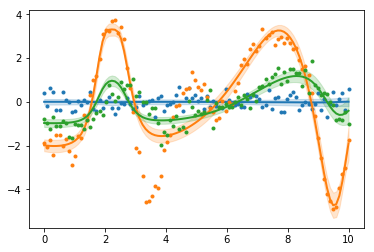

In [27]:
xtest = np.linspace(0, 10, npts)[:,None]
for i in range(output_dim):
    line, = plt.plot(t[l==i], y[l==i], '.')
    mu, var = m.predict_f(np.hstack((xtest, i+np.zeros_like(xtest))))
    plt.plot(xtest, mu, color=line.get_color(), lw=2)
    mu, var = mu.reshape(npts,), var.reshape(npts,)
    plt.fill_between(xtest.reshape(npts,), mu-2*np.sqrt(var), mu+2*np.sqrt(var), color=line.get_color(), alpha=0.2)

In [28]:
print(m)

<Parameter name:SVGP/kern/nn_rbf/variance [trainable] shape:() transform:+ve prior:None>
value: 0.1466415240121737

<Parameter name:SVGP/kern/nn_rbf/lengthscales [trainable] shape:() transform:+ve prior:None>
value: 0.08822358570174521

<Parameter name:SVGP/kern/nn_rbf/nn/W_0 [trainable] shape:(1, 5) transform:(none) prior:None>
value: [[ 0.11124392,  0.72802019,  0.22331367,  1.26466139, -1.3066925 ]]

<Parameter name:SVGP/kern/nn_rbf/nn/b_0 [trainable] shape:(5,) transform:(none) prior:None>
value: [-1.67025156,  0.93174015,  0.89151028, -2.76610794,  2.6488214 ]

<Parameter name:SVGP/kern/nn_rbf/nn/W_1 [trainable] shape:(5, 5) transform:(none) prior:None>
value: [[-1.05838881,  1.11511489, -0.38798087, -1.42171327,  0.01061737],
        [ 0.81813722, -0.16150624,  0.30709991, -0.20516836, -0.90835399],
        [ 0.50775956,  0.06274927, -0.11444982, -0.12223728, -1.03452931],
        [-0.2333801 , -0.50524522,  0.6164545 ,  1.96446271, -0.4352701 ],
        [ 0.73230069, -0.46282072

### Deep Learned Kernel Code

In [6]:
#https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html
def nn(npts):
    sess = tf.Session()
    K.set_session(sess)
    
    img = tf.placeholder(tf.float32, shape=(None,1))
    x = Dense(128, activation='relu')(img)
    x = Dense(128, activation='relu')(x)
    out = Dense(1, activation='relu')(x)
    return out, sess

In [7]:
#keras/tf part
h, sess = nn(npts)
h = tf.cast(h, gpflow.settings.tf_float)
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [8]:
#gpflow part
with gpflow.defer_build():
    kernel = gpflow.kernels.RBF(npts)
    #lik = gpflow.likelihoods.MultiClass(ndim)
    lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT()]*ndim)
    gp_model = gpflow.models.SVGP(h, Y, kernel, lik, np.ones(npts, gpflow.settings.np_float),
                                  num_latent=1, minibatch_size=None, num_data=npts)
# ^ so we say minibatch size is None to make sure we get DataHolder rather than minibatch data holder, which
# does not allow us to give in tensors. But we will handle all our minibatching outside.

In [9]:
gp_model.compile(sess)

ValueError: Index out of range using input dim 1; input has only 1 dims for '9/SVGP/conditional/strided_slice_2' (op: 'StridedSlice') with input shapes: [100], [2], [2], [2] and with computed input tensors: input[3] = <1 1>.

### Build model, format data arrays, train (works)

In [16]:
#arrange data
X = np.vstack((t,l)).T
Y = np.vstack((y,l)).T

#set up coregionalized kernel
input_dim = 1
coreg = gpflow.kernels.Coregion(input_dim, output_dim=ndim, rank=ndim, active_dims=[1])
k = gpflow.kernels.Exponential(1)
kern = k * coreg
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT()]*ndim)
        
m = gpflow.models.SVGP(X, Y, kern=kern, likelihood=lik, num_latent=1, Z=X[::3].copy())

In [17]:
#optimize
gpflow.train.ScipyOptimizer().minimize(m, maxiter=500)

/storage/work/ajs725/conda/install/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 223.357179
  Number of iterations: 501
  Number of functions evaluations: 577


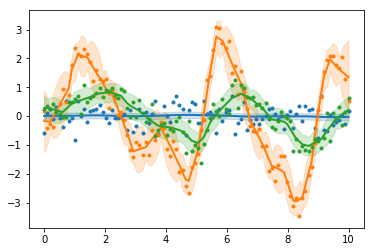

In [18]:
xtest = np.linspace(0, 10, npts)[:,None]
for i in range(ndim):
    line, = plt.plot(t[l==i], y[l==i], '.')
    mu, var = m.predict_f(np.hstack((xtest, i+np.zeros_like(xtest))))
    plt.plot(xtest, mu, color=line.get_color(), lw=2)
    mu, var = mu.reshape(npts,), var.reshape(npts,)
    plt.fill_between(xtest.reshape(npts,), mu-2*np.sqrt(var), mu+2*np.sqrt(var), color=line.get_color(), alpha=0.2)

In [20]:
#print(m)

### Part 3 - Try and Model this with a NN kernel and/or adding multiple GPs together
- https://github.com/GPflow/GPflow/issues/505 - end-to-end NN kernel with GP on top
- https://github.com/GPflow/GPflow/issues/297#issuecomment-267765077 - combining GPs
- https://gist.github.com/john-bradshaw/11bbf17dbca013d9fc3886a7bfe46840 - end to end training of NN + GP

In [14]:
#this is how to make d(t) = a_1 X_1(t) + a_2 X_2(t)
from functools import reduce
import tensorflow as tf
class ProductModel(gpflow.models.Model):
    def __init__(self, models):
        gpflow.model.Model.__init__(self)
        self.models = gpflow.param.ParamList(models)

    def build_likelihood(self):
        return reduce(tf.add, (m.build_likelihood() for m in self.models))
    
#This is how to make a NN kernel
from gpflow.params import Parameterized
from gpflow.kernels import RBF
def xavier(dim_in, dim_out):
    return np.random.randn(dim_in, dim_out)*(2./(dim_in+dim_out))**0.5

class NN(Parameterized):
    def __init__(self, dims):
        Parameterized.__init__(self)
        self.dims = dims
        for i, (dim_in, dim_out) in enumerate(zip(dims[:-1], dims[1:])):
            setattr(self, 'W_{}'.format(i), param.Param(xavier(dim_in, dim_out)))
            setattr(self, 'b_{}'.format(i), param.Param(np.zeros(dim_out)))

    def forward(self, X):
        if X is not None:
            for i in range(len(self.dims) - 1):
                W = getattr(self, 'W_{}'.format(i))
                b = getattr(self, 'b_{}'.format(i))
                X = tf.nn.tanh(tf.matmul(X, W) + b)
            return X

class NN_RBF(RBF):
    def __init__(self, nn, *args, **kw):
        RBF.__init__(self, *args, **kw)
        self.nn = nn
    
    def square_dist(self, X, X2):
        return RBF.square_dist(self, self.nn.forward(X), self.nn.forward(X2))

In [87]:
#arrange data
X = np.vstack((t,l)).T
Y = np.vstack((y,l)).T

#set up coregionalized kernel
input_dim = 1
coreg = gpflow.kernels.Coregion(input_dim, output_dim=ndim, rank=1, active_dims=[1])
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT()]*ndim)

#set up model 1
net = NN([1, npts, 1])  # for 1D inputs and a ndim GP
k1 = NN_RBF(net, 1) 
m = gpflow.svgp.SVGP(X, Y, kern=k1, likelihood=lik, num_latent=1,Z=X[::3].copy())
#m1 = gpflow.svgp.SVGP(X, Y, kern=k1, likelihood=lik, num_latent=1,Z=X[::3].copy())

# #set up model 2
# k2 = gpflow.kernels.Matern32(1) * coreg
# m2 = gpflow.svgp.SVGP(X, Y, kern=k2, likelihood=lik, num_latent=1,Z=X[::3].copy())

# m = ProductModel([m1,m2])

[1, 100, 1]


In [88]:
m.optimize(maxiter=500)

      fun: 375.87803260250251
 hess_inv: <5656x5656 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.29589716e+00,   0.00000000e+00,   8.02118722e-01, ...,
        -4.28253146e-07,   8.01897423e-07,   1.88566277e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 636
      nit: 501
   status: 1
  success: False
        x: array([  1.18480668e-01,   0.00000000e+00,   1.90609366e-01, ...,
        -2.72002392e-07,  -8.43521324e-07,   9.99999067e-01])

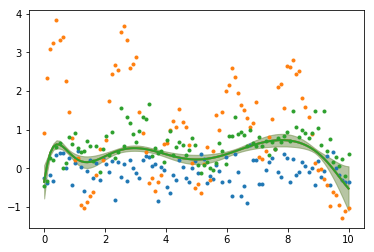

In [95]:
xtest = np.linspace(0, 10, npts)[:,None]
for i in np.arange(ndim):
    line, = plt.plot(t[l==i], y[l==i], '.')
    mu, var = m.predict_f(np.hstack((xtest, i+np.zeros_like(xtest))))
    plt.plot(xtest, mu, color=line.get_color(), lw=2)
    mu, var = mu.reshape(npts,), var.reshape(npts,)
    plt.fill_between(xtest.reshape(npts,), mu-2*np.sqrt(var), mu+2*np.sqrt(var), color=line.get_color(), alpha=0.2)

### Scratch

In [12]:
from gpflow.param import Parameterized

def xavier(dim_in, dim_out):
    return np.random.randn(dim_in, dim_out)*(2./(dim_in+dim_out))**0.5

class NN(Parameterized):
    def __init__(self, dims):
        Parameterized.__init__(self)
        self.dims = dims
        for i, (dim_in, dim_out) in enumerate(zip(dims[:-1], dims[1:])):
            setattr(self, 'W_{}'.format(i), Param(xavier(dim_in, dim_out)))
            setattr(self, 'b_{}'.format(i), Param(np.zeros(dim_out)))

    def forward(self, X):
        if X is not None:
            for i in range(len(self.dims) - 1):
                W = getattr(self, 'W_{}'.format(i))
                b = getattr(self, 'b_{}'.format(i))
                X = tf.nn.tanh(tf.matmul(X, W) + b)
            return X

ModuleNotFoundError: No module named 'gpflow.param'

In [46]:
#rearrange data into (nsteps,ndim)
time = np.array((t[l==1],t[l==2],t[l==3])).T
#time = t[l==1]
data = np.array((y[l==1],y[l==2],y[l==3])).T
#time = t[l==1]
#data = y[l==1]

train_frac, batch_size = 0.8, 10
split = int(train_frac*len(time))
#X_train, y_train = time[0:split], data[0:split]
#X_test, y_test = time[split:], data[split]
X_train, y_train = time[0:split,:], data[0:split,:]
X_test, y_test = time[split:,:], data[split,:]

data_ = {
    'train': (X_train, y_train),
    'test': (X_test, y_test)
}

# data_ = {
#     'train': (X_train.reshape(1,-1), y_train.reshape(1,-1)),
#     'test': (X_test.reshape(1,-1), y_test.reshape(1,-1))
# }

input_shape = X_train.shape
print input_shape

(80, 3)


In [47]:
gp_hypers = {'lik': -2.0, 'cov': [[-0.7], [0.0]]}

# Build the model
inputs = Input(shape=input_shape)
hidden = Dense(input_shape[0], activation='relu')(inputs)
hidden = Dense(input_shape[0], activation='relu')(hidden)
#rnn = SimpleRNN(32)(inputs)
gp = GP(gp_hypers,
        batch_size=batch_size,
        nb_train_samples=len(X_train))
outputs = [gp(hidden)]
#outputs = [gp(rnn)]  # 2 GPs assigned to each output dimension
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
loss = [gen_gp_loss(gp) for gp in model.output_layers]
model.compile(optimizer=Adam(1e-2), loss=loss)
model.summary()

AssertionError: 

In [43]:
epochs = 5
history = train(model, data_, callbacks=[], gp_n_iter=5,
                epochs=epochs, batch_size=batch_size, verbose=1)

Training...
error: `ME' undefined near line 81 column 7
error: called from:
error:   /storage/home/ajs725/tf-ml/lib/python2.7/site-packages/oct2py/_pyeval.m at line 81, column 7


Oct2PyError: Value "nlZ" does not exist in Octave workspace

In [159]:
#https://github.com/alshedivat/keras-gp/blob/master/examples/msgp_mlp_kin40k.py
def assemble_mlp(input_shape, output_shape, batch_size, nb_train_samples):
    inputs = Input(shape=input_shape)
    hidden = Dense(10, activation='relu')(inputs)
    hidden = Dense(10, activation='relu')(hidden)
    #hidden = Dense(input_shape, activation='relu')(hidden)
    gp = GP(hyp={
                'lik': np.log(0.3),
                'mean': [],
                'cov': [[0.5], [1.0]],
            },
            inf='infGrid', dlik='dlikGrid',
            opt={'cg_maxit': 2000, 'cg_tol': 1e-6},
            mean='meanZero', cov='covSEiso',
            update_grid=1,
            grid_kwargs={'eq': 1, 'k': 70.},
            batch_size=batch_size,
            nb_train_samples=nb_train_samples)
    outputs = []
    for i in range(output_shape[1]):
        outputs.append()
    return Model(inputs=inputs, outputs=outputs)

In [168]:
model = assemble_mlp(input_shape,output_shape,batch_size,split)

AssertionError: 

In [116]:
loss = [gen_gp_loss(gp) for gp in model.output_layers]
model.compile(optimizer=Adam(1e-4), loss=loss)

In [117]:
epochs = 5
history = train(model, data_, callbacks=[], gp_n_iter=5,
                epochs=epochs, batch_size=batch_size, verbose=1)

Training...


ValueError: Error when checking input: expected input_16 to have shape (None, 80) but got array with shape (80, 1)

### Scratch

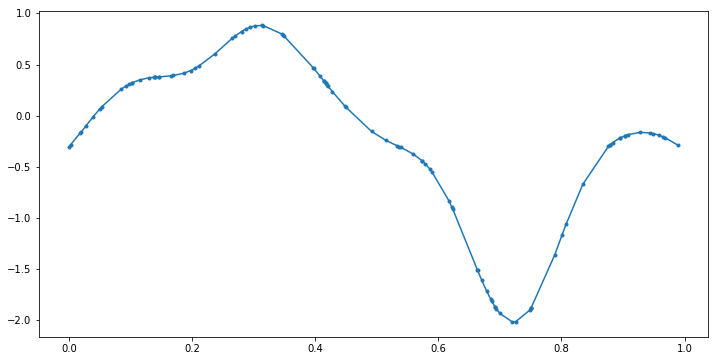

In [42]:
#generate data from a GP with a given kernel, but these are not necessarily correlated timeseries, just draws from 
#a GP with a specified kernel.


In [ ]:
dataset_path = ''
dataa = np.load(dataset_path)

In [36]:
input_shape = (10, 2)  # 10 time steps, 2 dimensions
batch_size = 32
nb_train_samples = 512
gp_hypers = {'lik': -2.0, 'cov': [[-0.7], [0.0]]}

inputs = Input(shape=input_shape)
rnn = SimpleRNN(32)(inputs)
gp = GP(gp_hypers,
        batch_size=batch_size,
        nb_train_samples=nb_train_samples)
outputs = [gp(rnn)]
model = Model(inputs=inputs, outputs=outputs)

GP configuration:
{'cov': '{@covSEiso}',
 'dcov': '@dcovSEiso',
 'dlik': '@(varargin) dlikExact(varargin{:}, opt)',
 'inf': '{@(varargin) infExact(varargin{:}, opt)}',
 'lik': '{@likGauss}',
 'mean': '{@meanZero}'}


In [46]:
outputs[0]

<tf.Tensor 'gp_1/Identity:0' shape=(?, 32) dtype=float32>

In [49]:
import tensorflow as tf
sess = tf.Session()
with sess.as_default():
    gp(rnn).eval()

InvalidArgumentError: You must feed a value for placeholder tensor 'input_1' with dtype float
	 [[Node: input_1 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'input_1', defined at:
  File "/gpfs/group/ebf11/default/sw/python-2.7.11-tf-1.0.0/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/gpfs/group/ebf11/default/sw/python-2.7.11-tf-1.0.0/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-bc67349297ba>", line 6, in <module>
    inputs = Input(shape=input_shape)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/keras/engine/topology.py", line 1436, in Input
    input_tensor=tensor)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/keras/engine/topology.py", line 1347, in __init__
    name=self.name)
  File "/storage/home/ajs725/tf-ml/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 442, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/gpfs/group/ebf11/default/sw/python-2.7.11-tf-1.0.0/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1505, in placeholder
    name=name)
  File "/gpfs/group/ebf11/default/sw/python-2.7.11-tf-1.0.0/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2148, in _placeholder
    name=name)
  File "/gpfs/group/ebf11/default/sw/python-2.7.11-tf-1.0.0/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/gpfs/group/ebf11/default/sw/python-2.7.11-tf-1.0.0/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2334, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/gpfs/group/ebf11/default/sw/python-2.7.11-tf-1.0.0/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_1' with dtype float
	 [[Node: input_1 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
